# BEN JACKANY CAPSTONE PROJECT
## FLIGHT DELAYS PREDICTIONS

![fig_06](img/fig_06.png)


### MACHINE LEARNING MODELS ( LOGISTIC)

### Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample


In [3]:
dfm_dl_2019 = pd.read_csv('../Data/dfm_dl_2019.csv')

In [4]:
dfm_dl_2019.shape

(697697, 25)

first step is to get rid of of columns that I won't be using, thus I did some research to find out what are the real reasons flight are delayed. source: <a href="https://www.claimcompass.eu/blog/why-is-my-flight-delayed/">Link</a>

### Data Engineering and Modeling

#### A delayed flight is a flight that is delayed 15 minutes or more. The ARR_DEL15 column show a zero when the flight is not delayed and 1 when the flight is delayed

In [5]:
# this means for the top 20 arrival cities, DL is late only 15% of the time. The vast majority of flight arrive on time
dfm_dl_2019['ARR_DEL15'].value_counts(normalize= True) 

0.0    0.851619
1.0    0.148381
Name: ARR_DEL15, dtype: float64

### Let's rename ARR_DEL15:FLIGHT_STATUS

In [6]:
dfm_dl_2019 = dfm_dl_2019.rename(columns = {'ARR_DEL15': 'FLIGHT_STATUS'})

In [7]:
dfm_dl_2019.head(2)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST,DEST_STATE_ABR,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,FLIGHT_STATUS,CANCELLED,FLIGHTS,DISTANCE
0,2019,1,1,4,5,2019-01-04,DL,LGA,NY,New York,MSP,MN,Minnesota,1055,1052.0,-3.0,0.0,0.0,1237.0,-50.0,0.0,0.0,0.0,1.0,1020.0
1,2019,1,1,4,5,2019-01-04,DL,BNA,TN,Tennessee,ATL,GA,Georgia,918,916.0,-2.0,0.0,0.0,1129.0,-1.0,0.0,0.0,0.0,1.0,214.0


### Let's get rid of the columns we wont' be using

In [8]:
dfm_dl_2019 = dfm_dl_2019.drop(columns = ['YEAR', 'FL_DATE', 'ORIGIN_STATE_NM', 'DEST_STATE_NM', 'CRS_DEP_TIME', 
                                        'DEP_TIME','CRS_DEP_TIME','DEP_TIME','DEP_DEL15','ARR_TIME','CANCELLED',
                                        'FLIGHTS', 'DEP_DELAY','DEP_DELAY_NEW', 'ARR_DELAY','ARR_DELAY_NEW' ])

In [9]:
dfm_dl_2019.head(2)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,FLIGHT_STATUS,DISTANCE
0,1,1,4,5,DL,LGA,NY,MSP,MN,0.0,1020.0
1,1,1,4,5,DL,BNA,TN,ATL,GA,0.0,214.0


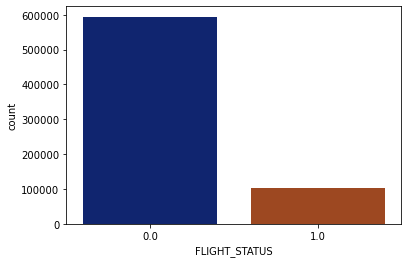

In [10]:
sns.countplot(x="FLIGHT_STATUS", palette="dark", data=dfm_dl_2019);

In [11]:
dfm_dl_2019['FLIGHT_STATUS'].value_counts(normalize= True)

0.0    0.851619
1.0    0.148381
Name: FLIGHT_STATUS, dtype: float64

### Our classes are imbalanced, and the ratio of on-time arrivals  to delay flights is 85:15.

In [12]:
dfm_dl_2019.corr()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FLIGHT_STATUS,DISTANCE
QUARTER,1.000000,0.969934,-0.004313,-0.000982,-0.010354,-0.003291
MONTH,0.969934,1.000000,-0.006178,0.010652,-0.010900,-0.003104
DAY_OF_MONTH,-0.004313,-0.006178,1.000000,0.009177,-0.000032,0.005401
DAY_OF_WEEK,-0.000982,0.010652,0.009177,1.000000,0.002508,0.009729
FLIGHT_STATUS,-0.010354,-0.010900,-0.000032,0.002508,1.000000,0.025740
DISTANCE,-0.003291,-0.003104,0.005401,0.009729,0.025740,1.000000


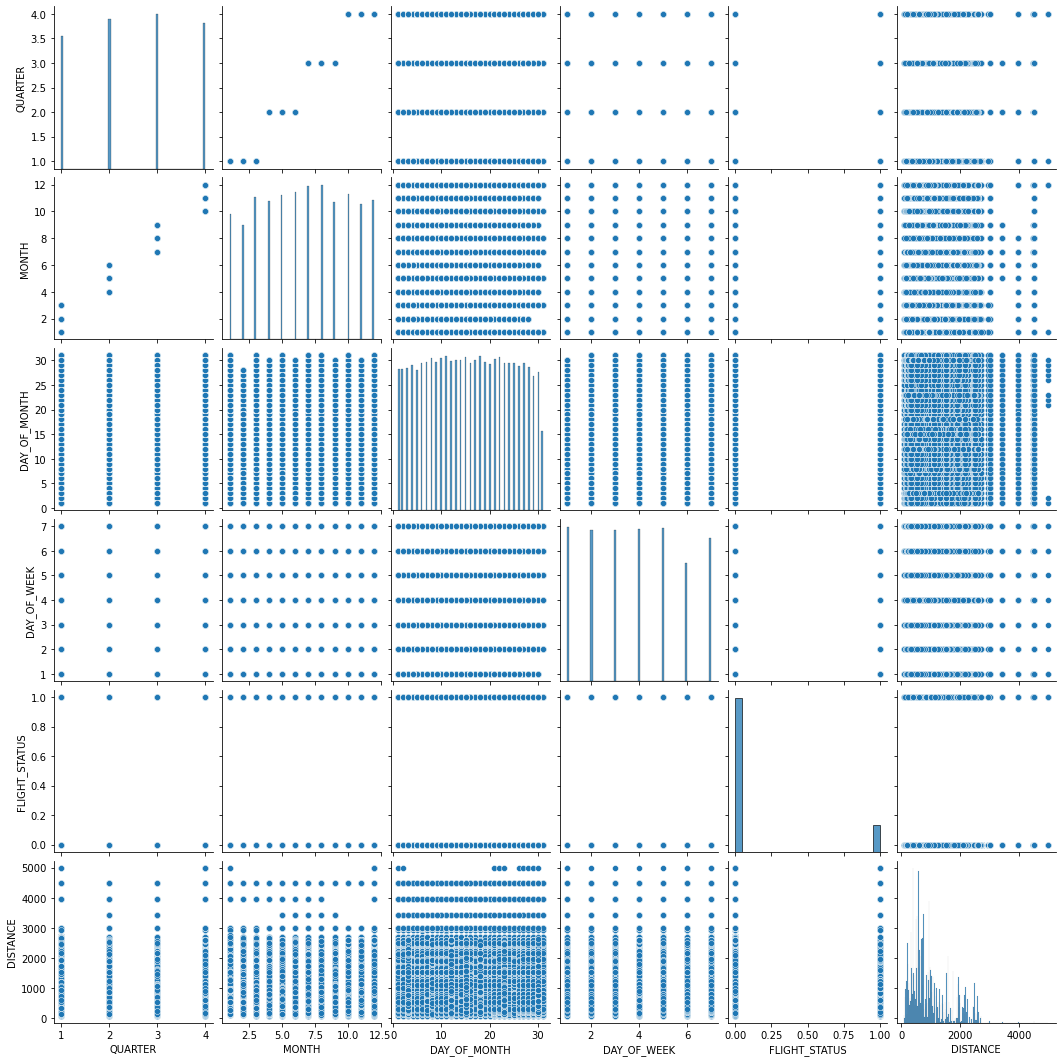

In [13]:
sns.pairplot(dfm_dl_2019)

In [14]:
dfm_dl_2019.shape

(697697, 11)

In [15]:
dfm_dl_2019

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,FLIGHT_STATUS,DISTANCE
0,1,1,4,5,DL,LGA,NY,MSP,MN,0.0,1020.0
1,1,1,4,5,DL,BNA,TN,ATL,GA,0.0,214.0
2,1,1,4,5,DL,MCO,FL,JFK,NY,0.0,944.0
3,1,1,4,5,DL,SLC,UT,ATL,GA,0.0,1590.0
4,1,1,4,5,DL,PHX,AZ,ATL,GA,0.0,1587.0
...,...,...,...,...,...,...,...,...,...,...,...
697692,4,12,12,4,DL,BOS,MA,MSP,MN,0.0,1124.0
697693,4,12,12,4,DL,SLC,UT,MSP,MN,0.0,991.0
697694,4,12,12,4,DL,PVD,RI,ATL,GA,0.0,903.0
697695,4,12,12,4,DL,ATL,GA,ORD,IL,0.0,606.0


### For machine learning we need to convert categorical features into numerical

In [16]:
df = pd.get_dummies(dfm_dl_2019, drop_first= True)

In [17]:
df.head(5)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FLIGHT_STATUS,DISTANCE,ORIGIN_ABQ,ORIGIN_AGS,ORIGIN_ALB,ORIGIN_ANC,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_BDL,ORIGIN_BHM,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CLE,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_COS,ORIGIN_CRW,ORIGIN_CVG,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_ELP,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLL,ORIGIN_FNT,ORIGIN_FSD,ORIGIN_GEG,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GTF,ORIGIN_HDN,ORIGIN_HNL,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HSV,ORIGIN_IAD,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_ILM,ORIGIN_IND,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JNU,ORIGIN_KOA,ORIGIN_LAS,ORIGIN_LAX,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEM,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MLB,ORIGIN_MOB,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MYR,ORIGIN_OAK,ORIGIN_OGG,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIT,ORIGIN_PNS,ORIGIN_PSC,ORIGIN_PSP,ORIGIN_PVD,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDU,ORIGIN_RIC,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_RSW,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SAV,ORIGIN_SBN,ORIGIN_SDF,ORIGIN_SEA,ORIGIN_SFO,ORIGIN_SJC,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SNA,ORIGIN_SRQ,ORIGIN_STL,ORIGIN_STT,ORIGIN_STX,ORIGIN_SYR,ORIGIN_TLH,ORIGIN_TPA,ORIGIN_TRI,ORIGIN_TUL,ORIGIN_TUS,ORIGIN_TVC,ORIGIN_TYS,ORIGIN_VPS,ORIGIN_XNA,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,ORIGIN_STATE_ABR_KS,ORIGIN_STATE_ABR_KY,ORIGIN_STATE_ABR_LA,ORIGIN_STATE_ABR_MA,ORIGIN_STATE_ABR_MD,ORIGIN_STATE_ABR_ME,ORIGIN_STATE_ABR_MI,ORIGIN_STATE_ABR_MN,ORIGIN_STATE_ABR_MO,ORIGIN_STATE_ABR_MS,ORIGIN_STATE_ABR_MT,ORIGIN_STATE_ABR_NC,ORIGIN_STATE_ABR_ND,ORIGIN_STATE_ABR_NE,ORIGIN_STATE_ABR_NH,ORIGIN_STATE_ABR_NJ,ORIGIN_STATE_ABR_NM,ORIGIN_STATE_ABR_NV,ORIGIN_STATE_ABR_NY,ORIGIN_STATE_ABR_OH,ORIGIN_STATE_ABR_OK,ORIGIN_STATE_ABR_OR,ORIGIN_STATE_ABR_PA,ORIGIN_STATE_ABR_PR,ORIGIN_STATE_ABR_RI,ORIGIN_STATE_ABR_SC,ORIGIN_STATE_ABR_SD,ORIGIN_STATE_ABR_TN,ORIGIN_STATE_ABR_TX,ORIGIN_STATE_ABR_UT,ORIGIN_STATE_ABR_VA,ORIGIN_STATE_ABR_VI,ORIGIN_STATE_ABR_VT,ORIGIN_STATE_ABR_WA,ORIGIN_STATE_ABR_WI,ORIGIN_STATE_ABR_WV,ORIGIN_STATE_ABR_WY,DEST_BOS,DEST_DCA,DEST_DEN,DEST_DFW,DEST_DTW,DEST_FLL,DEST_JFK,DEST_LAS,DEST_LAX,DEST_LGA,DEST_MCO,DEST_MSP,DEST_ORD,DEST_RDU,DEST_SAN,DEST_SEA,DEST_SFO,DEST_SLC,DEST_TPA,DEST_STATE_ABR_CO,DEST_STATE_ABR_FL,DEST_STATE_ABR_GA,DEST_STATE_ABR_IL,DEST_STATE_ABR_MA,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_NC,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_WA
0,1,1,4,5,0.0,1020.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,4,5,0.0,214.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [18]:
dfm_dl_2019['ORIGIN_STATE_ABR'].nunique()

51

In [19]:
dfm_dl_2019['DEST'].nunique()

20

In [20]:
X = df.drop(columns ='FLIGHT_STATUS')

In [21]:
X

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DISTANCE,ORIGIN_ABQ,ORIGIN_AGS,ORIGIN_ALB,ORIGIN_ANC,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_BDL,ORIGIN_BHM,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CLE,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_COS,ORIGIN_CRW,ORIGIN_CVG,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_ELP,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLL,ORIGIN_FNT,ORIGIN_FSD,ORIGIN_GEG,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GTF,ORIGIN_HDN,ORIGIN_HNL,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HSV,ORIGIN_IAD,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_ILM,ORIGIN_IND,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JNU,ORIGIN_KOA,ORIGIN_LAS,ORIGIN_LAX,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEM,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MLB,ORIGIN_MOB,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MYR,ORIGIN_OAK,ORIGIN_OGG,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIT,ORIGIN_PNS,ORIGIN_PSC,ORIGIN_PSP,ORIGIN_PVD,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDU,ORIGIN_RIC,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_RSW,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SAV,ORIGIN_SBN,ORIGIN_SDF,ORIGIN_SEA,ORIGIN_SFO,ORIGIN_SJC,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SNA,ORIGIN_SRQ,ORIGIN_STL,ORIGIN_STT,ORIGIN_STX,ORIGIN_SYR,ORIGIN_TLH,ORIGIN_TPA,ORIGIN_TRI,ORIGIN_TUL,ORIGIN_TUS,ORIGIN_TVC,ORIGIN_TYS,ORIGIN_VPS,ORIGIN_XNA,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,ORIGIN_STATE_ABR_KS,ORIGIN_STATE_ABR_KY,ORIGIN_STATE_ABR_LA,ORIGIN_STATE_ABR_MA,ORIGIN_STATE_ABR_MD,ORIGIN_STATE_ABR_ME,ORIGIN_STATE_ABR_MI,ORIGIN_STATE_ABR_MN,ORIGIN_STATE_ABR_MO,ORIGIN_STATE_ABR_MS,ORIGIN_STATE_ABR_MT,ORIGIN_STATE_ABR_NC,ORIGIN_STATE_ABR_ND,ORIGIN_STATE_ABR_NE,ORIGIN_STATE_ABR_NH,ORIGIN_STATE_ABR_NJ,ORIGIN_STATE_ABR_NM,ORIGIN_STATE_ABR_NV,ORIGIN_STATE_ABR_NY,ORIGIN_STATE_ABR_OH,ORIGIN_STATE_ABR_OK,ORIGIN_STATE_ABR_OR,ORIGIN_STATE_ABR_PA,ORIGIN_STATE_ABR_PR,ORIGIN_STATE_ABR_RI,ORIGIN_STATE_ABR_SC,ORIGIN_STATE_ABR_SD,ORIGIN_STATE_ABR_TN,ORIGIN_STATE_ABR_TX,ORIGIN_STATE_ABR_UT,ORIGIN_STATE_ABR_VA,ORIGIN_STATE_ABR_VI,ORIGIN_STATE_ABR_VT,ORIGIN_STATE_ABR_WA,ORIGIN_STATE_ABR_WI,ORIGIN_STATE_ABR_WV,ORIGIN_STATE_ABR_WY,DEST_BOS,DEST_DCA,DEST_DEN,DEST_DFW,DEST_DTW,DEST_FLL,DEST_JFK,DEST_LAS,DEST_LAX,DEST_LGA,DEST_MCO,DEST_MSP,DEST_ORD,DEST_RDU,DEST_SAN,DEST_SEA,DEST_SFO,DEST_SLC,DEST_TPA,DEST_STATE_ABR_CO,DEST_STATE_ABR_FL,DEST_STATE_ABR_GA,DEST_STATE_ABR_IL,DEST_STATE_ABR_MA,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_NC,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_WA
0,1,1,4,5,1020.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,4,5,214.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [22]:
y = df['FLIGHT_STATUS']

In [23]:
X.shape

(697697, 241)

In [24]:
y.shape

(697697,)

### LOGISTIC REGRESSION

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= .2,  random_state=42)

In [26]:
scaler = StandardScaler()

In [27]:
scaled_X_train = scaler.fit_transform(X_train)

In [28]:
scaled_X_test = scaler.transform(X_test)

In [29]:
logReg = LogisticRegression()

In [30]:
logReg.fit(scaled_X_train, y_train)

LogisticRegression()

In [31]:
#examine train and test scores
print(f'The training score is {logReg.score(X_train, y_train)}')
print(f'The testing score is {logReg.score(X_test, y_test)}')

The training score is 0.8514539815858262
The testing score is 0.8522789164397305


In [32]:
logReg.coef_

array([[ 4.04741438e-03, -3.53015190e-02, -3.85243850e-04,
         1.25818302e-02, -1.54181539e-02, -1.15687151e-02,
        -4.70701161e-03, -1.92100988e-02, -2.98633684e-02,
         1.74215888e-02,  2.65419302e-05, -1.19004529e-02,
        -3.76510084e-03, -1.75088677e-02, -4.54410038e-03,
         9.76265551e-03, -1.43200286e-02, -1.19624784e-02,
        -2.60818237e-02, -1.60004766e-02,  2.41273844e-02,
        -5.25726655e-03,  1.87741385e-03, -1.57302483e-02,
         9.83072555e-03, -9.66884031e-04,  6.38443497e-03,
        -5.77185142e-03, -4.73042240e-03,  1.19652436e-03,
        -5.79033800e-03, -1.49308168e-02, -2.93735794e-03,
        -1.27826309e-02, -9.76390024e-03, -2.33705611e-02,
         4.56265598e-03, -4.98473661e-03, -6.40035729e-03,
        -7.09335083e-03,  4.73990858e-03, -5.24574989e-04,
         1.46495320e-02,  5.22626523e-03,  4.25141765e-02,
        -1.55007496e-03,  8.44874164e-03, -1.04276447e-02,
         4.02929710e-03, -1.18942015e-02,  2.58257091e-0

In [33]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FLIGHT_STATUS,DISTANCE,ORIGIN_ABQ,ORIGIN_AGS,ORIGIN_ALB,ORIGIN_ANC,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_BDL,ORIGIN_BHM,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CLE,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_COS,ORIGIN_CRW,ORIGIN_CVG,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_ELP,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLL,ORIGIN_FNT,ORIGIN_FSD,ORIGIN_GEG,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GTF,ORIGIN_HDN,ORIGIN_HNL,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HSV,ORIGIN_IAD,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_ILM,ORIGIN_IND,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JNU,ORIGIN_KOA,ORIGIN_LAS,ORIGIN_LAX,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEM,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MLB,ORIGIN_MOB,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MYR,ORIGIN_OAK,ORIGIN_OGG,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIT,ORIGIN_PNS,ORIGIN_PSC,ORIGIN_PSP,ORIGIN_PVD,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDU,ORIGIN_RIC,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_RSW,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SAV,ORIGIN_SBN,ORIGIN_SDF,ORIGIN_SEA,ORIGIN_SFO,ORIGIN_SJC,ORIGIN_SJU,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SNA,ORIGIN_SRQ,ORIGIN_STL,ORIGIN_STT,ORIGIN_STX,ORIGIN_SYR,ORIGIN_TLH,ORIGIN_TPA,ORIGIN_TRI,ORIGIN_TUL,ORIGIN_TUS,ORIGIN_TVC,ORIGIN_TYS,ORIGIN_VPS,ORIGIN_XNA,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,ORIGIN_STATE_ABR_KS,ORIGIN_STATE_ABR_KY,ORIGIN_STATE_ABR_LA,ORIGIN_STATE_ABR_MA,ORIGIN_STATE_ABR_MD,ORIGIN_STATE_ABR_ME,ORIGIN_STATE_ABR_MI,ORIGIN_STATE_ABR_MN,ORIGIN_STATE_ABR_MO,ORIGIN_STATE_ABR_MS,ORIGIN_STATE_ABR_MT,ORIGIN_STATE_ABR_NC,ORIGIN_STATE_ABR_ND,ORIGIN_STATE_ABR_NE,ORIGIN_STATE_ABR_NH,ORIGIN_STATE_ABR_NJ,ORIGIN_STATE_ABR_NM,ORIGIN_STATE_ABR_NV,ORIGIN_STATE_ABR_NY,ORIGIN_STATE_ABR_OH,ORIGIN_STATE_ABR_OK,ORIGIN_STATE_ABR_OR,ORIGIN_STATE_ABR_PA,ORIGIN_STATE_ABR_PR,ORIGIN_STATE_ABR_RI,ORIGIN_STATE_ABR_SC,ORIGIN_STATE_ABR_SD,ORIGIN_STATE_ABR_TN,ORIGIN_STATE_ABR_TX,ORIGIN_STATE_ABR_UT,ORIGIN_STATE_ABR_VA,ORIGIN_STATE_ABR_VI,ORIGIN_STATE_ABR_VT,ORIGIN_STATE_ABR_WA,ORIGIN_STATE_ABR_WI,ORIGIN_STATE_ABR_WV,ORIGIN_STATE_ABR_WY,DEST_BOS,DEST_DCA,DEST_DEN,DEST_DFW,DEST_DTW,DEST_FLL,DEST_JFK,DEST_LAS,DEST_LAX,DEST_LGA,DEST_MCO,DEST_MSP,DEST_ORD,DEST_RDU,DEST_SAN,DEST_SEA,DEST_SFO,DEST_SLC,DEST_TPA,DEST_STATE_ABR_CO,DEST_STATE_ABR_FL,DEST_STATE_ABR_GA,DEST_STATE_ABR_IL,DEST_STATE_ABR_MA,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_NC,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_WA
0,1,1,4,5,0.0,1020.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,4,5,0.0,214.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [35]:
y_pred = logReg.predict(scaled_X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.8522789164397305

In [37]:
confusion_matrix(y_test, y_pred)

array([[118927,      0],
       [ 20613,      0]])

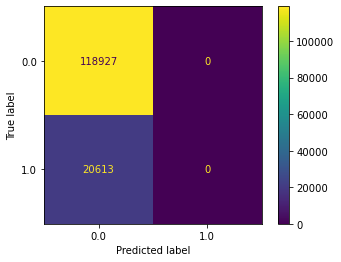

In [38]:
plot_confusion_matrix(logReg, scaled_X_test, y_test);

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92    118927
         1.0       0.00      0.00      0.00     20613

    accuracy                           0.85    139540
   macro avg       0.43      0.50      0.46    139540
weighted avg       0.73      0.85      0.78    139540



/Users/bjackany/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bjackany/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bjackany/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import precision_score, recall_score

In [41]:
precision_score(y_test, y_pred)

/Users/bjackany/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [42]:
recall_score(y_test, y_pred)

0.0

In [43]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

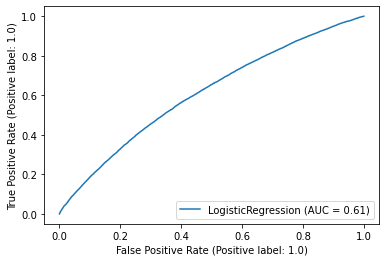

In [44]:
plot_roc_curve(logReg, scaled_X_test, y_test)

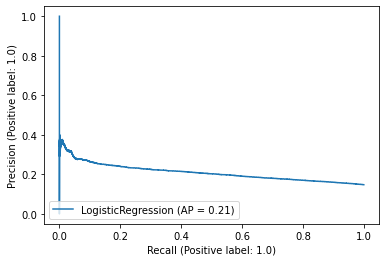

In [45]:
plot_precision_recall_curve(logReg,scaled_X_test, y_test);